# Predicting patient matches from incomplete data
### Tony Zhang and David Zhang

* * *

### 1) Introduction 

For this project, we decided to use an algorithm that employed levenshtein's algorithm to detect discrepencies between two patient fields and determine whether the patients are in the same group. With our modified algorithm, we were able to achieve **99.9% accuracy** on the test data set, without hardcoding to any specific patients in the given data set. We also considered other algorithms, such as soundex tokens and metaphone, but given the time constraint and the fact that levenshtein was able to accurately predict a large majority of patient matches, we did not implement any additional algorithms and left that for future work.

#### Data Cleaning
We performed basic data cleaning before running our algorithm. This included things like converting all alphabetic characters to lowercase, converting gender to a binary value, and removing non-alphanumeric characters for certain fields, to make comparison easier.

To handle null fields, if either patient had a null value in a certain field, we disregarded it, as we did not have enough information to make an informed guess based on any null value.

#### Matching Algorithm

For the matching algorithm, we used levenshtein's algorithm to determine the edit distance between two fields (ie "Lara" and "Laura" would have an edit distance of 1 by removing the "u" in "Laura"). We evaluated the majority, but not all, fields (patient first name, last name, middle initial, date of birth, etc.), taking into consideration the importance of the field in correctly identifying a match. For example, first name + date of birth was a crucial combination, as two people with the same first name and date of birth (accounting for possible typos) are extremely likely to be the same person (as there is unlikely to be an error typing in the wrong first name *and* date of birth), whereas only taking into account last name + date of birth could lead to confusion if the two patients are twins. We tested various combinations of fields and used the one that provided the highest accuracy.

We used a bottom-up criteria when deciding if two patients were the same (ie had the same GroupID). When evaluating a field between two patients, if the edit distance was greater than a certain threshold, we counted it as an error. If the total number of errors amongst all fields evalauted was greater than 1, then we returned false (indicating that the two patients do not have the same GroupID)*. If the total number of errors was less than one, we returned true (indicating that the two patients do have the same GroupID).

>*The exception to this was for date of birth; if date of birth had more than 3 discrepencies, we automatically returned false since it is more likely that the patients with different DOB's are different people, rather than the same person, except with > 3 typos on the date of birth.


#### Accuracy

We measured accuracy by running each patient in the test dataset against every other patient, and comparing the result of the algorithm against whether the GroupID's actually matched. We were able to obtain 99.89% accuracy - out of 20100 total tests, 20078 tests were accurate, with only 10 false positives (matching two patients with different GroupIDs) and 12 false negatives (not matching two patients with the same GroupIDs). We modified the cutoff values for the algorithm to try to ensure as even a number of false positives and negatives as possible.
* * * 


In [1]:
import json
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# load patients from csv file
def load_patients(path):
    file = pd.read_csv(path)
    return file

patients = load_patients("./PatientMatchingData.csv")
patients.head()

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apt 9,Mount Vernon,New York,10557.0
1,1,2,NaN,Suttin,James,Power,9/21/1945,Male,1859 Sullivan Parkway,#2,...,California,93726.0,NaN,NaN,NaN,2 Erie Crossing,Apartment # 9,Mount Vernon,New York,10557.0
2,1,3,247028705-7,Sutton,J,Power,9/20/1945,Male,1858 Sullivan Parkway,NaN,...,CA,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,NaN,Sutton,NaN,Power,9/20/1954,Male,1858 Sullivan Parkway,NaN,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,NaN,SUTTON,NaN,POWER,9/20/1954,Male,1858 SULLIVAN PKWAY,APT 2,...,California,93726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Levenshtein Distance Algorithm

def levenshtein(seq1, seq2):
    # if either is null, return 0
    if pd.isna(seq1) or pd.isna(seq2)or seq1 == 'nan' or seq2 == 'nan':
        return 0
    
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
#     print (matrix)
    return (matrix[size_x - 1, size_y - 1])

Data clean-up

In [4]:
# show columns and data type for each column
print(patients.columns)
print([type(x) for x in patients.columns])

Index(['GroupID', 'PatientID', 'Patient Acct #', 'First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code'],
      dtype='object')
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [11]:
# treat all columns (besides ID and account #'s) as alphabetic (ie string) for now
alphabeticCols = ['First Name', 'MI',
       'Last Name', 'Date of Birth', 'Sex', 'Current Street 1',
       'Current Street 2', 'Current City', 'Current State', 'Current Zip Code',
       'Previous First Name', 'Previous MI', 'Previous Last Name',
       'Previous Street 1', 'Previous Street 2', 'Previous City',
       'Previous State', 'Previous Zip Code']

patientsClean = patients.copy()


# change everything to lowercase
for col in alphabeticCols:
    patientsClean.loc[:,col] = patientsClean.loc[:,col].astype(str).str.lower()
    
# make gender binary (0 for male 2 for female 1 for unknown)
patientsClean.loc[:,'Sex'] = 0 if patientsClean.loc[:,'Sex'][0] == 'M' else 2 if patientsClean.loc[:,'Sex'][0] == 'F' else 1
    
    
patientsClean

,GroupID,PatientID,Patient Acct #,First Name,MI,Last Name,Date of Birth,Sex,Current Street 1,Current Street 2,...,Current State,Current Zip Code,Previous First Name,Previous MI,Previous Last Name,Previous Street 1,Previous Street 2,Previous City,Previous State,Previous Zip Code
0,1,1,247028705-7,sutton,j,power,9/20/1945,1,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,2 erie crossing,apt 9,mount vernon,new york,10557.0
1,1,2,NaN,suttin,james,power,9/21/1945,1,1859 sullivan parkway,#2,...,california,93726.0,nan,nan,nan,2 erie crossing,apartment # 9,mount vernon,new york,10557.0
2,1,3,247028705-7,sutton,j,power,9/20/1945,1,1858 sullivan parkway,nan,...,ca,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
3,1,4,NaN,sutton,nan,power,9/20/1954,1,1858 sullivan parkway,nan,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
4,1,5,NaN,sutton,nan,power,9/20/1954,1,1858 sullivan pkway,apt 2,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
5,2,6,NaN,sutton,nan,powers,12/15/2000,1,1619 maple lane,nan,...,california,93726.0,sutton,nan,lore,nan,nan,nan,nan,nan
6,2,7,NaN,sutton,nan,powers,12/15/2000,1,1619 maple lane,nan,...,california,93726.0,nan,nan,nan,nan,nan,nan,nan,nan
7,3,8,757393348-7,mikel,l,trayton,9/20/2000,1,715 jana point,nan,...,arizona,85219.0,nan,nan,nan,81089 kenwood park,nan,chattanooga,tennessee,37416.0
8,3,9,757393348-7,mikel,lee,trayton,9/20/2000,1,715 jana point,nan,...,arizona,85219.0,nan,nan,nan,81089 kenwood park,nan,chattanooga,tennessee,37416.0
9,3,10,757393348-7,michael,nan,trayton,9/20/2000,1,715 jana point,nan,...,az,85219.0,nan,nan,nan,81089 kenwood park,7,chattanooga,tennessee,37416.0


In [6]:
# verify if patient1 and patient2 are the same person
# need to determine optimal cutoffs (ie what levenshtein score is considered "different" enough to be 2 different people?)
def verify(patient1, patient2):
    numErrors = 0 # error considered as a field that is significantly different
    # consider first name
    if levenshtein(patient1['First Name'], patient2['First Name']) > 2:
        numErrors += 1
    # consider middle name
    if patient1['MI'] != 'nan' and patient2['MI'] != 'nan':
        if patient1['MI'][0] != patient2['MI'][0]:
            numErrors += 1
    # consider last name
    if levenshtein(patient1['Last Name'], patient2['Last Name']) > 2:
        numErrors += 1
    # consider DOB - more strict evaluation b/c less likely to mistype date of birth > 3 typos
    if levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 3:
        # make sure there aren't any swapped character typos
        # TODO: swapped regex ?
        return False
    elif levenshtein(patient1['Date of Birth'], patient2['Date of Birth']) > 2:
        numErrors += 1
    # consider gender
    if patient1['Sex'] != patient2['Sex']:
        numErrors += 1
    # consider current street 1
    if levenshtein(patient1['Current Street 1'], patient2['Current Street 1']) > 2:
        numErrors += 1
    # consider current city
    if levenshtein(patient1['Current City'], patient2['Current City']) > 2:
        numErrors += 1
    # consider zip
    if levenshtein(patient1['Current Zip Code'], patient2['Current Zip Code']) > 2:
            numErrors += 1
    return numErrors <= 1

In [7]:
# Evaluation function to test accuracy
total = 0
correct = 0
falsePos = 0
falseNeg = 0
for index, patient in patientsClean.iterrows():
    for index1, patient1 in patientsClean.iterrows():
        if(index1 > index):
            result = verify(patient, patient1)
            ID1 = patient['GroupID']
            ID2 = patient1['GroupID']
            if result == True and ID1 == ID2 or result == False and ID1 != ID2:
                correct += 1
            elif result == True and ID1 != ID2:
#                 print('false positive found between patients: ', patient, " and ", patient1)
                falsePos += 1
            elif result == False and ID1 == ID2:
#                 print('false negative found between patients: ', patient['PatientID'], " and ", patient1['PatientID'])
                falseNeg += 1
            total += 1

print("correct: ", correct)
print("total: ", total)
print("false positives: ", falsePos)
print("false negatives: ", falseNeg)
print("accuracy: ", correct/total)
        

correct:  20078
total:  20100
false positives:  10
false negatives:  12
accuracy:  0.998905472636816


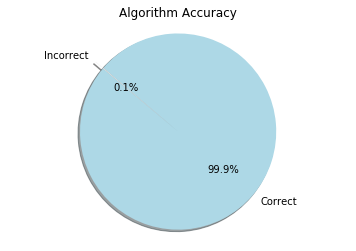

In [12]:
# Data to plot
labels =["Correct","Incorrect"]
sizes = [correct, total-correct]
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.title("Algorithm Accuracy")
plt.show()

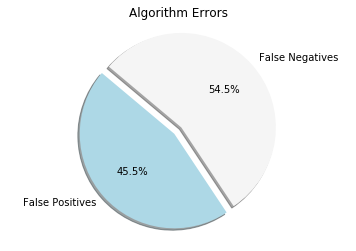

In [13]:
# Data to plot
labels =["False Positives","False Negatives"]
sizes = [falsePos, falseNeg]
colors = ["lightblue","whitesmoke"]
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,)
plt.axis('equal')
plt.title("Algorithm Errors")
plt.show()